In [132]:
#Python
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
from IPython.core.display import Image, display
import cv2
from tqdm import tqdm
import math
from datetime import datetime
import matplotlib.pyplot as plt                        
%matplotlib inline


#Neural Net
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint

#Map
import folium
# from geopy import geocoders
# import geocoder
import json
import vincent
import branca

#image information
import PIL
from IPython.core.display import Image, display
import matplotlib.pyplot as plt
from PIL.ExifTags import TAGS, GPSTAGS
import os

In [133]:
# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
CLASSES = len(dog_names)

In [134]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [135]:
bottleneck_features = np.load('DogVGG16Data.npz')
train_VGG = bottleneck_features['train']
valid_VGG = bottleneck_features['valid']
test_VGG = bottleneck_features['test']

In [136]:
### Load the model weights with the best validation loss.
DogVGG16_model = Sequential()
DogVGG16_model.add(GlobalAveragePooling2D(input_shape=(train_VGG.shape[1:])))

DogVGG16_model.add(layers.Dense(256))
DogVGG16_model.add(layers.BatchNormalization())
DogVGG16_model.add(layers.Activation('relu'))
DogVGG16_model.add(layers.Dropout(0.5))

DogVGG16_model.add(layers.Dense(CLASSES))
DogVGG16_model.add(layers.BatchNormalization())
DogVGG16_model.add(layers.Activation('softmax'))
DogVGG16_model.load_weights('weights.best.VGG16.hdf5')

In [137]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
"""
1/ Extract the bottleneck features corresponding to the chosen CNN model.
2/ Supply the bottleneck features as input to the model to return the predicted vector. 
    Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3/ Use the dog_names array defined in Step 0 of this notebook to return the corresponding breed
"""
def extract_VGG16(tensor):
    return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def VGG_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = DogVGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def dog_breed_algorithm(img_path):
    display(Image(img_path,width=400,height=400))
    
    
    if dog_detector(img_path) == 1:
        print("I think it is a dog. Its predicted breed is: ")
        return VGG_predict_breed(img_path)
    else:
        print("Could not identify a dog. Please try again.")
        return VGG_predict_breed(img_path)

In [138]:
# define a ResNet50 model for the DOG DETECTION
ResNet50_model = ResNet50(weights='imagenet')

In [139]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    """Dog classes in imagenet are between 151 and 268"""
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

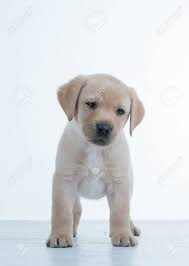

I think it is a dog. Its predicted breed is: 
Labrador_retriever


In [140]:
print(dog_breed_algorithm('labrador2.jpg'))

## Image Information

In [152]:
def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    
    exif_data = {}
    try:
        info = image._getexif()
        if info:
            for tag, value in info.items():
                decoded = TAGS.get(tag, tag)
                if decoded == "GPSInfo":
                    gps_data = {}
                    for t in value:
                        sub_decoded = GPSTAGS.get(t, t)
                        gps_data[sub_decoded] = value[t]

                        exif_data[decoded] = gps_data
                else:
                    exif_data[decoded] = value
    except Exception as e:
        print(e)
    return exif_data

def _get_if_exist(data, key):
    if key in data:
        return data[key]
    return None

def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    d0 = value[0][0]
    d1 = value[0][1]
    d = float(d0) / float(d1)

    m0 = value[1][0]
    m1 = value[1][1]
    m = float(m0) / float(m1)

    s0 = value[2][0]
    s1 = value[2][1]
    s = float(s0) / float(s1)

    return d + (m / 60.0) + (s / 3600.0)

def get_datetime(exif_data):
    if "DateTimeOriginal" in exif_data:
        datetime_pict = datetime.strptime(exif_data['DateTimeOriginal'],"%Y:%m:%d %H:%M:%S")
        date_picture = datetime_pict.date()
        time_picture = datetime_pict.time()
    return date_picture, time_picture
        

def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:
        gps_info = exif_data["GPSInfo"]

        gps_latitude = _get_if_exist(gps_info, "GPSLatitude")
        gps_latitude_ref = _get_if_exist(gps_info, 'GPSLatitudeRef')
        gps_longitude = _get_if_exist(gps_info, 'GPSLongitude')
        gps_longitude_ref = _get_if_exist(gps_info, 'GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            if gps_latitude_ref != "N":                     
                lat = 0 - lat

            lon = _convert_to_degress(gps_longitude)
            if gps_longitude_ref != "E":
                lon = 0 - lon
    return lat, lon

img = PIL.Image.open('g_test.jpg')
exif_data = get_exif_data(img)
latitude, longitude = get_lat_lon(exif_data)
date_pict, time_pict = get_datetime(exif_data)

latitude, longitude, date_pict, time_pict

(32.071758270000004,
 34.76939392083333,
 datetime.date(2019, 1, 1),
 datetime.time(16, 26, 38))

## MAP

In [159]:
img = PIL.Image.open('test_dogs/IMG_9562.jpg')
exif_data = get_exif_data(img)
latitude, longitude = get_lat_lon(exif_data)
date_pict, time_pict = get_datetime(exif_data)
latitude, longitude, date_pict, time_pict

(32.07273055555556,
 34.773291666666665,
 datetime.date(2019, 1, 1),
 datetime.time(17, 23, 6))

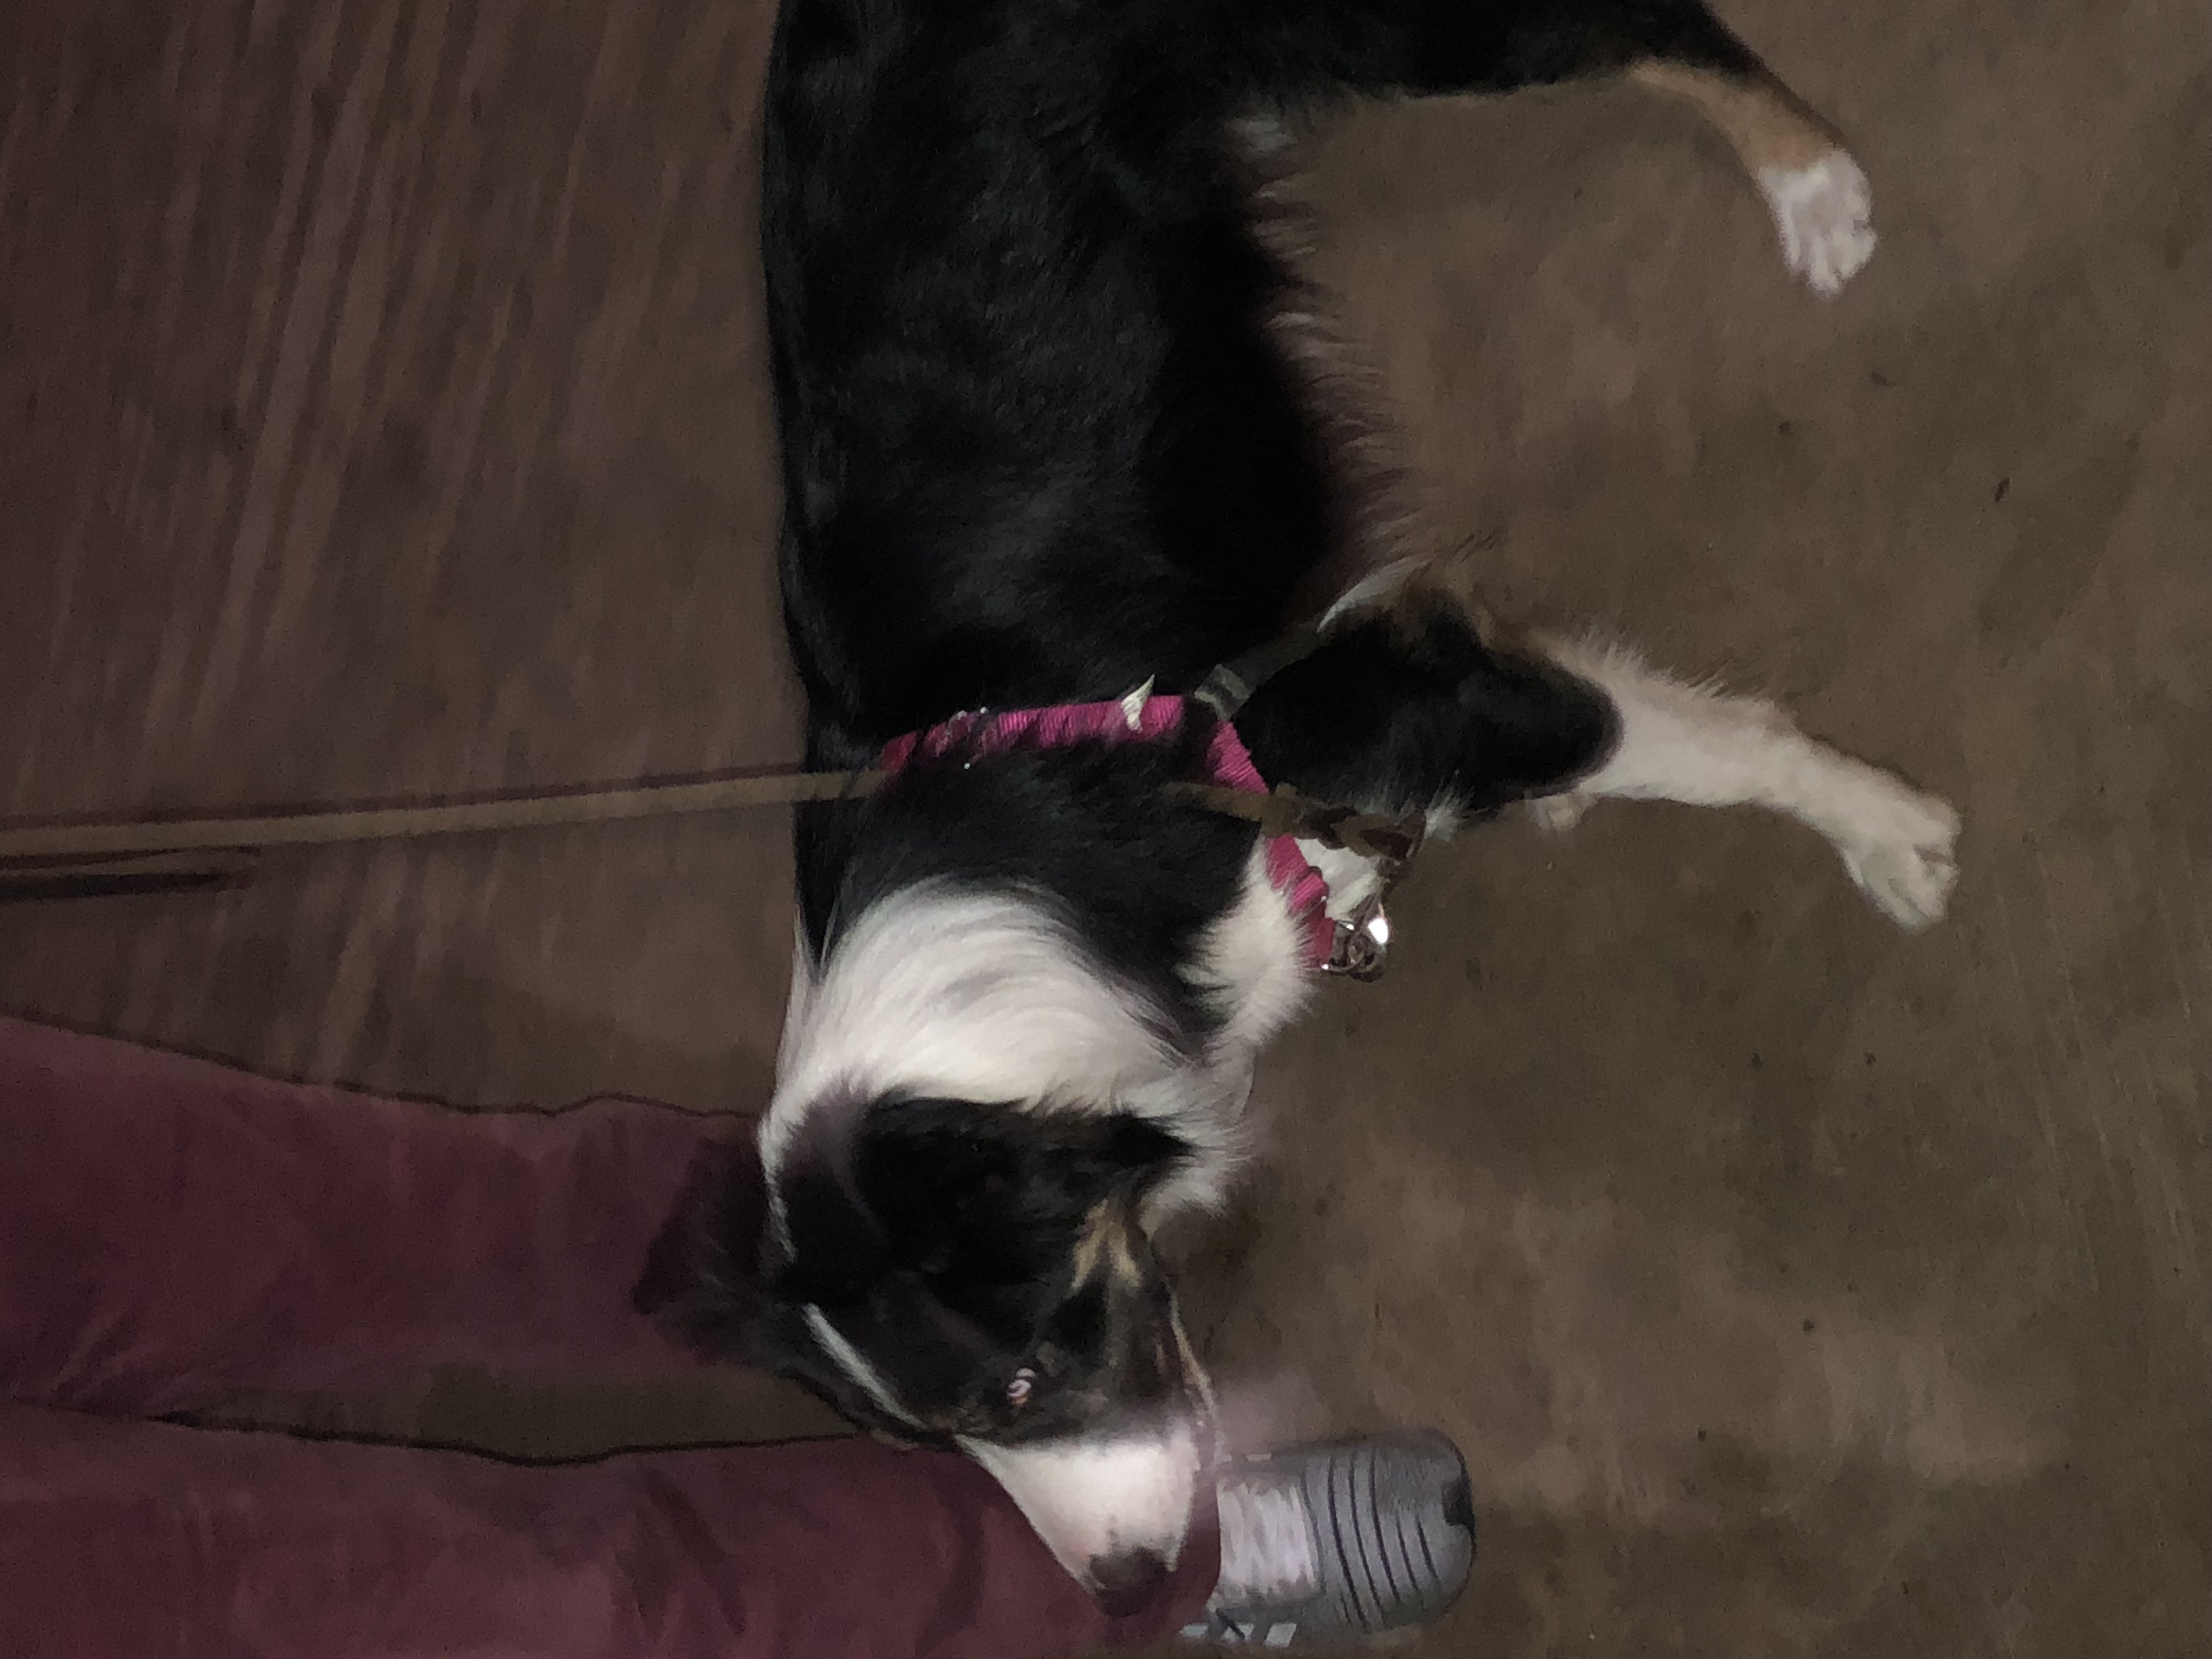

I think it is a dog. Its predicted breed is: 


,img,breed,time,date,latitude,longitude
test,IMG_9562.jpg,Border_collie,17:23:06,2019-01-01,32.072731,34.773292


In [160]:
dict_dogs = {'img': 'IMG_9562.jpg', 'breed':dog_breed_algorithm('test_dogs/IMG_9562.jpg'), 'time':time_pict, 
             'date':date_pict,'latitude':latitude, 'longitude':longitude}
df_dogs = pd.DataFrame(dict_dogs, index=['test'])
df_dogs.head()

In [204]:
# NORMAL
dest_map = folium.Map(location=[32.063292, 34.772731], zoom_start=13.2)
 

for i in range(0,len(df_dogs)):
    pop_up = df_dogs.iloc[i]['img']
#     sentiment = str(round(df_sentiment.iloc[i]['sentiment_avg']*100,2))
    hashtag = df_dogs.iloc[i]['breed']
    print(hashtag)
    
    
    folium.Marker(location = [df_dogs.iloc[i]['latitude'], df_dogs.iloc[i]['longitude']], 
                  popup = hashtag,
                  icon = folium.Icon(color='red')).add_to(dest_map)
#     else:

#         folium.Marker(location = [df_sentiment.iloc[i]['longitude'], df_sentiment.iloc[i]['latitude']], 
#                       popup = "<b>{}</b> | S:{}% | #:<i>{}</i>".format(pop_up, sentiment, hashtag),
#                       icon = folium.Icon(color='green')).add_to(dest_map)
    
 
dest_map.save('general_country_analysis.html')

Border_collie
